<a href="https://colab.research.google.com/github/arturoliduena/cifar10-image-recognition/blob/main/versions/cnn_cifar10_tf2_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [3]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170508288/170498071 [==============================] - 6s 0us/step


In [5]:
y_train_label = y_train

y_test
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [6]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]

## 2. Arquitectura de red del modelo - Proyecto 0


In [7]:
vgg = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(32, 32,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [8]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
#new_output_layer = ks.layers.Conv2D(512, (1,1), activation='relu')(output)

vgg_model = Model(vgg.input, new_output_layer)

In [9]:
vgg_model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [10]:
print(vgg_model.trainable)

True


In [11]:
for layer in vgg_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd3d4ae2b10> input_1 True
<keras.layers.convolutional.Conv2D object at 0x7fd3cce0ad50> block1_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7fd3cc32b810> block1_conv2 True
<keras.layers.pooling.MaxPooling2D object at 0x7fd3cba892d0> block1_pool True
<keras.layers.convolutional.Conv2D object at 0x7fd3c04e6bd0> block2_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7fd3c04ec250> block2_conv2 True
<keras.layers.pooling.MaxPooling2D object at 0x7fd3c04e6090> block2_pool True
<keras.layers.convolutional.Conv2D object at 0x7fd3c04f1350> block3_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7fd3c04f6b10> block3_conv2 True
<keras.layers.convolutional.Conv2D object at 0x7fd3c04fac90> block3_conv3 True
<keras.layers.pooling.MaxPooling2D object at 0x7fd3c04eeb10> block3_pool True
<keras.layers.convolutional.Conv2D object at 0x7fd3c0503f90> block4_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7fd3c050c7d

In [12]:
for layer in vgg_model.layers:
  layer.trainable = False

In [13]:
for layer in vgg_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd3d4ae2b10> input_1 False
<keras.layers.convolutional.Conv2D object at 0x7fd3cce0ad50> block1_conv1 False
<keras.layers.convolutional.Conv2D object at 0x7fd3cc32b810> block1_conv2 False
<keras.layers.pooling.MaxPooling2D object at 0x7fd3cba892d0> block1_pool False
<keras.layers.convolutional.Conv2D object at 0x7fd3c04e6bd0> block2_conv1 False
<keras.layers.convolutional.Conv2D object at 0x7fd3c04ec250> block2_conv2 False
<keras.layers.pooling.MaxPooling2D object at 0x7fd3c04e6090> block2_pool False
<keras.layers.convolutional.Conv2D object at 0x7fd3c04f1350> block3_conv1 False
<keras.layers.convolutional.Conv2D object at 0x7fd3c04f6b10> block3_conv2 False
<keras.layers.convolutional.Conv2D object at 0x7fd3c04fac90> block3_conv3 False
<keras.layers.pooling.MaxPooling2D object at 0x7fd3c04eeb10> block3_pool False
<keras.layers.convolutional.Conv2D object at 0x7fd3c0503f90> block4_conv1 False
<keras.layers.convolutional.Conv2D object at 0

In [14]:
model = ks.Sequential()


model.add(ks.layers.InputLayer(input_shape=(512))) 
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.4))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

## 3. Optimizador, función error


In [16]:
new_adam = Adam(learning_rate=2e-5)

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=new_adam, metrics=['accuracy'])

In [18]:
#vgg.compile(optimizer='Adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

Obtenemos un array con todas las labels de CIFAR10

In [19]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


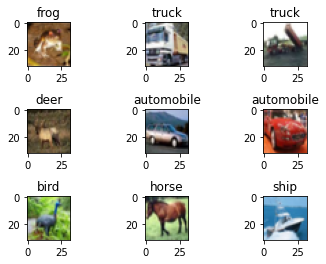

In [20]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [21]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [22]:
# Llevamos las imagenes desde su origen al cuello de botella de VGG16, justo después del Flatten()
def alcuellodebotella(model, x_data):
  return model.predict(x_data)

In [23]:
x_train_post_vgg = alcuellodebotella(vgg_model, x_train_scaled)
x_test_post_vgg = alcuellodebotella(vgg_model, x_test_scaled)
x_val_post_vgg = alcuellodebotella(vgg_model, x_val_scaled)

## 5.1 Callbacks

In [24]:
# Callback con EarlyStopping basado en Accuracy
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=10)

# Callback con EarlyStopping basada en Loss
callback_loss = EarlyStopping(monitor='val_loss', patience=10)

callback_modelcheckpoint = ModelCheckpoint('/tmp/modelchk', monitor='val_accuracy', 
                                           verbose=1, save_best_only=True, 
                                           save_weights_only=True)

In [25]:
t = time.perf_counter()

In [26]:
history = model.fit(x_train_post_vgg, y_train, epochs=200, 
                    use_multiprocessing=False, batch_size=32, callbacks=[callback_modelcheckpoint, callback_loss, callback_accuracy],
                    validation_data=(x_val_post_vgg, y_val))

Epoch 1/200
1245/1250 [============================>.] - ETA: 0s - loss: 2.0798 - accuracy: 0.2389
Epoch 1: val_accuracy improved from -inf to 0.42700, saving model to /tmp/modelchk
1250/1250 [==============================] - 8s 5ms/step - loss: 2.0787 - accuracy: 0.2393 - val_loss: 1.6907 - val_accuracy: 0.4270
Epoch 2/200
1246/1250 [============================>.] - ETA: 0s - loss: 1.7135 - accuracy: 0.3873
Epoch 2: val_accuracy improved from 0.42700 to 0.47570, saving model to /tmp/modelchk
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7131 - accuracy: 0.3874 - val_loss: 1.4822 - val_accuracy: 0.4757
Epoch 3/200
1246/1250 [============================>.] - ETA: 0s - loss: 1.5679 - accuracy: 0.4428
Epoch 3: val_accuracy improved from 0.47570 to 0.49980, saving model to /tmp/modelchk
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5681 - accuracy: 0.4428 - val_loss: 1.4077 - val_accuracy: 0.4998
Epoch 4/200
1245/1250 [==========================

In [27]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:08:58.636346


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [28]:
_, acc = model.evaluate(x_test_post_vgg, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 62.880


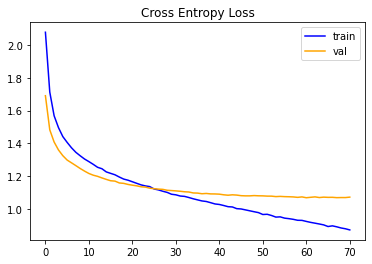

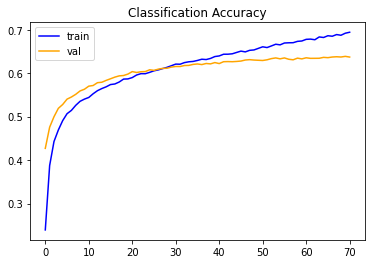

In [29]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [30]:
predictions = model.predict(x_test_post_vgg)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [31]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


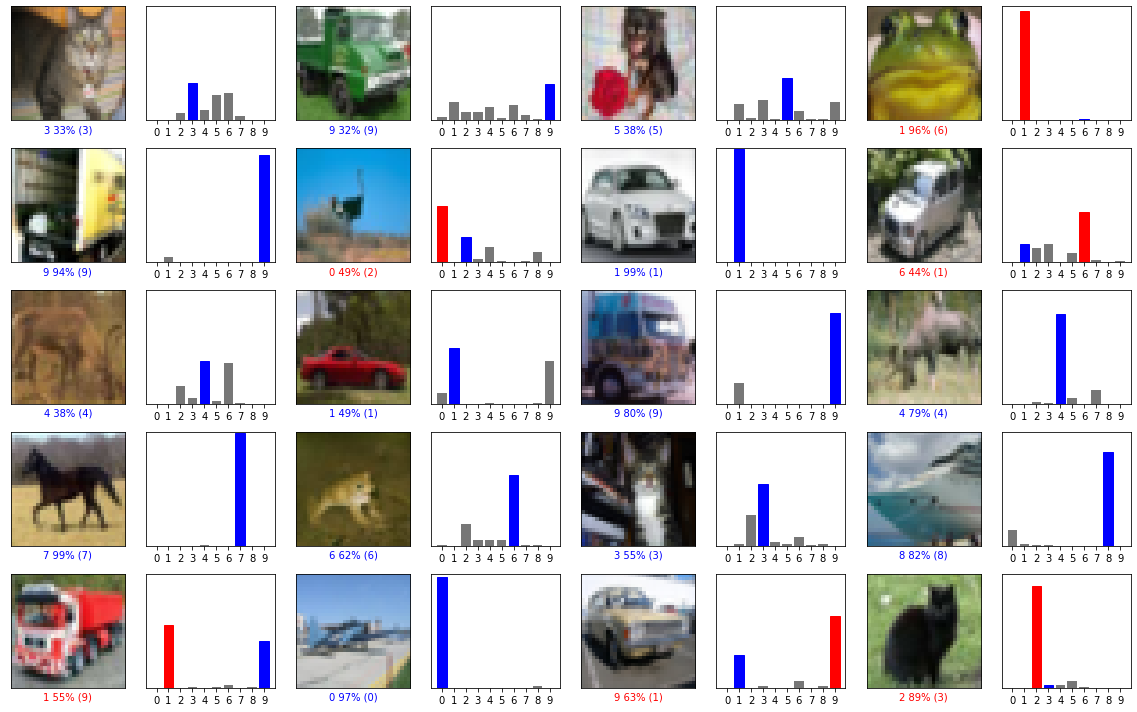

In [32]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [33]:
ruta_googledrive = "/content/drive/MyDrive/" # A revisar en vuestra instancia

model.save(ruta_googledrive+'cifar10_base_model.h5')